In [1]:
from scipy.integrate import *
import sympy as smp
from numpy import *
import Reflectivity as ref
import Setting_Layers as sl
import matplotlib.pyplot as plt

In [2]:
dc = 0.79
a = 1/(sqrt(2*pi))

p = lambda w_i: (dc + (a/2.7)* exp(-(((w_i - 845)/30)**2))) * (dc + (a/2.7)* exp(-(((w_i - 853)/15)**2))) * (1.01 + (a/3)* exp(-(((w_i - 845)/42)**2)))


In [3]:
def set_index_3(lambda_i):
    ref_index = []
    material = [21, 13, 16]
    for i in range(3):
        ref_index.append(sl.set_index(material[i], lambda_i*1E-9))
    return ref_index

In [4]:
idx = lambda w_i: set_index_3(w_i)
r = lambda theta, lambda_i: ref.reflectivity(3, [1, 50*1E-9, 1], idx(lambda_i), theta*pi/180, lambda_i*1e-9)

    

In [5]:
def f(w_i, theta):
    return (r(theta, w_i)*p(w_i))


In [6]:

integrals = [[a, quad(f, 500,1000, args=(a))[0]] for a in linspace(65, 73, 128)]

C:\Users\Adeilson\AppData\Local\Temp\ipykernel_12652\841044308.py:1: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integrals = [[a, quad(f, 500,1000, args=(a))[0]] for a in linspace(65, 73, 128)]


In [7]:
R = array(integrals).T[1] / quad(p, 500, 1000)[0]
r = R/max(R)

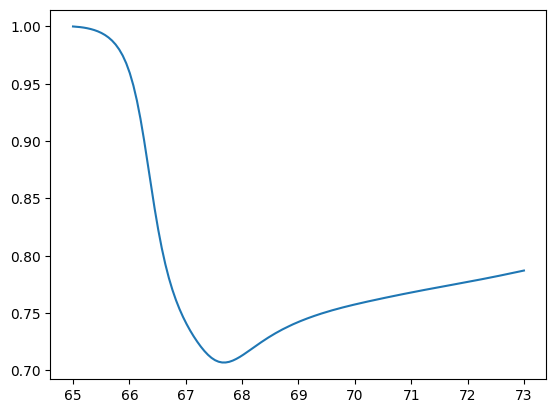

In [8]:
plt.plot(linspace(65, 73, 128), r)
